# Example Simulations in One Dimension
We are interested in the problem of whether it is ever easier to estimate (in an empirical Bayes sense) the average posterior of the latent parameters than it is to estimate the prior of the latent parameters.

In [27]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import npeb
%reload_ext autoreload
%autoreload 2
from npeb.GLMixture import GLMixture
import itertools
from scipy.linalg import sqrtm, inv
from scipy.spatial import distance_matrix
import ot
from itertools import product
from joblib import Parallel, delayed
import pickle

## Generate Data

We will first write methods to generate data according to three different kinds of priors.

In [21]:
def generate_discrete_theta(support, probs, size):
    Theta = np.random.choice(support, size=size, p=probs)
    return Theta.reshape(-1, 1)

def generate_normal_mixture_theta(means, variances, weights, size):
    components = np.random.choice(len(weights), size=size, p=weights)
    Theta = np.array([np.random.normal(loc=means[c], scale=np.sqrt(variances[c])) for c in components])
    return Theta.reshape(-1, 1)

def generate_t_mixture_theta(dfs, locs, scales, weights, size):
    components = np.random.choice(len(weights), size=size, p=weights)
    Theta = np.array([np.random.standard_t(df=dfs[c]) * scales[c] + locs[c] for c in components])
    return Theta.reshape(-1, 1)

def generate_Z(theta, sigma):
    Z = theta + np.random.normal(loc=0, scale=sigma, size=theta.shape)
    return Z.reshape(-1, 1)

def mse(y_hat, y_true):
    y_hat = np.asarray(y_hat)
    y_true = np.asarray(y_true)
    return np.mean((y_hat - y_true)**2)

def mse_regret(y_emp, y_true, y_oracle):
    return mse(y_emp, y_true) - mse(y_oracle, y_true)

In [22]:
class OneSimulation:
  def __init__(self, prior_type, prior_params, n, sigma2, n_supp=150):
    self.prior_type = prior_type
    self.prior_params = prior_params
    self.n = n
    self.sigma2 = sigma2
    self.n_supp = n_supp # this defines the number of support points for which we should estimate/use for our prior. should be generated from true distribution for oracle; across a grid for empirical.
    self.Theta = self.generate_theta()
    self.Z = generate_Z(self.Theta, np.sqrt(sigma2))

  def generate_theta(self):
    if self.prior_type == "discrete":
        support = self.prior_params['support']
        probs = self.prior_params['probs']
        Theta = generate_discrete_theta(support, probs, self.n)
    elif self.prior_type == "normal_mixture":
        means = self.prior_params['support']
        variances = self.prior_params['variances']
        weights = self.prior_params['probs']
        Theta = generate_normal_mixture_theta(means, variances, weights, self.n)
    elif self.prior_type == "t_mixture":
        dfs = self.prior_params['dfs']
        means = self.prior_params['support']
        variances = self.prior_params['variances']
        weights = self.prior_params['probs']
        Theta = generate_t_mixture_theta(dfs, means, variances, weights, self.n)
    else:
        raise ValueError("Unsupported prior type")
    return Theta
  
  def get_observations(self):
    return self.Z
  
  def get_oracle_estimates(self):
    if self.prior_type == "discrete":
        support = self.prior_params['support']
        probs = self.prior_params['probs']
        prior = generate_discrete_theta(support, probs, self.n_supp)
    elif self.prior_type == "normal_mixture":
        means = self.prior_params['support']
        variances = self.prior_params['variances']
        weights = self.prior_params['probs']
        prior = generate_normal_mixture_theta(means, variances, weights, self.n_supp)
    elif self.prior_type == "t_mixture":
        dfs = self.prior_params['dfs']
        means = self.prior_params['support']
        variances = self.prior_params['variances']
        weights = self.prior_params['probs']
        prior = generate_t_mixture_theta(dfs, means, variances, weights, self.n_supp)
    else:
        raise ValueError("Unsupported prior type")
    prec = np.ones_like(self.Theta) / self.sigma2
    ob_model = GLMixture(prec_type="diagonal")
    ob_model.set_params(atoms=prior, weights=np.ones(self.n_supp)/self.n_supp)
    ob_means = ob_model.posterior_mean(self.Z, prec)
    ob_indices, ob_samples = ob_model.posterior_sample(self.Z, prec, n_samples=self.n)
    return prior, ob_means, ob_indices, ob_samples
  
  def get_eb_estimates(self,):
    z_min, z_max = np.min(self.Z), np.max(self.Z)
    grid = np.linspace(z_min, z_max, self.n_supp).reshape(-1, 1)
    prec = np.ones_like(self.Theta) / self.sigma2
    eb_model = GLMixture(prec_type="diagonal", atoms_init=grid)
    eb_model.fit(self.Z, prec)
    prior, weights = eb_model.get_params()
    eb_means = eb_model.posterior_mean(self.Z, prec)
    eb_indices, eb_samples = eb_model.posterior_sample(self.Z, prec, n_samples=self.n)
    return weights, prior, eb_means, eb_indices, eb_samples
  
  def get_similarity_metrics(self, estimates):
    o_prior, ob_means, ob_indices, ob_samples = estimates['oracle']
    eb_weights, eb_prior, eb_means, eb_indices, eb_samples = estimates['eb']
    prior_dist = stats.wasserstein_distance(o_prior.flatten(), eb_prior.flatten(), u_weights=None, v_weights=eb_weights.flatten())
    denoise_regret = mse_regret(eb_means, self.Theta, ob_means)
    post_dist = stats.wasserstein_distance(ob_samples.flatten(), eb_samples.flatten())
    
    return {
        'prior_dist': prior_dist,
        'denoise_regret': denoise_regret,
        'post_dist': post_dist
    }
  
  def run_simulation(self):
    estimates = {}
    estimates['oracle'] = self.get_oracle_estimates()
    estimates['eb'] = self.get_eb_estimates()
    metrics = self.get_similarity_metrics(estimates)
    return metrics

In [ ]:
support = np.array([-3, 3])
probs = np.array([0.5, 0.5])
tau2 = np.array([0.1, 0.1])
dfs = np.array([3, 3])

n_supp = 500

prior_params = {
    'support': support,
    'probs': probs,
    'variances': tau2,
    'dfs': dfs
}

sim = OneSimulation(prior_type="normal_mixture", prior_params=prior_params, n=2500, sigma2=1.0, n_supp=n_supp)
metrics = sim.run_simulation()
print(metrics)

Here are some tests to try and understand why sometimes the solver fails.

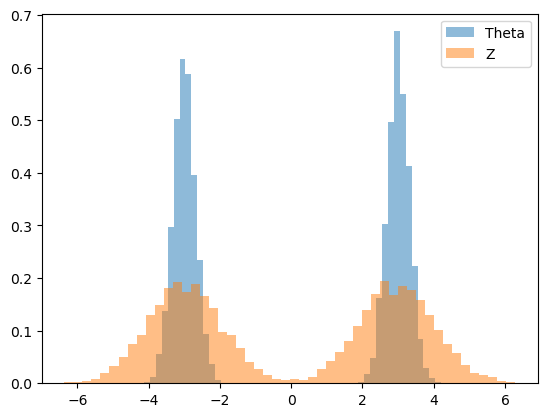

Computing kernel matrix: done.
Solving for discretized NPMLE: done.


[np.float64(-2.1466565990489026),
 np.float64(-2.14665659708346),
 np.float64(-2.1466565952953767),
 np.float64(-2.146656593607347),
 np.float64(-2.1466565919875595),
 np.float64(-2.146656590417407),
 np.float64(-2.1466565888850795),
 np.float64(-2.1466565873827523),
 np.float64(-2.146656585905101),
 np.float64(-2.1466565844484315),
 np.float64(-2.1466565830101376)]

In [38]:
Theta = generate_normal_mixture_theta(support, tau2, probs, 10_000)
Z = generate_Z(Theta, np.sqrt(1.0))

plt.hist(Theta, bins=50, density=True, alpha=0.5, label='Theta')
plt.hist(Z, bins=50, density=True, alpha=0.5, label='Z')
plt.legend()
plt.show()

grid = np.linspace(-np.max(np.abs(Z)), np.max(np.abs(Z)), n_supp).reshape(-1, 1)

test = GLMixture(prec_type="diagonal", atoms_init=grid)
test.fit(Z, np.ones_like(Theta))

In [31]:
state = {
  "Theta": Theta,
  "Z": Z,
  "model": test,
  "grid": grid
}

with open('test_fail_3000.pkl', "wb") as f:
    pickle.dump(state, f)